In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

2024-02-18 18:16:21.227215: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 18:16:21.227329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 18:16:21.368304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import pandas as pd

glioma_tumor_dir = [ r'/kaggle/input/brain-tumors-256x256/Data/glioma_tumor']

meningioma_tumor_dirs = [
    r'/kaggle/input/brain-tumors-256x256/Data/meningioma_tumor'
]

normal_dirs = [
    r'/kaggle/input/brain-tumors-256x256/Data/normal'
]

pituitary_tumor_dirs = [
    r'/kaggle/input/brain-tumors-256x256/Data/pituitary_tumor'
]

filepaths = []
labels = []
dict_lists = [glioma_tumor_dir, meningioma_tumor_dirs,normal_dirs, pituitary_tumor_dirs]
class_labels = ['Glioma Tumor', 'Meningioma Tumor', 'Normal', 'Pituitary Tumor']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Tumors_data = pd.concat([Fseries, Lseries], axis=1)
Tumors_df = pd.DataFrame(Tumors_data)
print(Tumors_df.head())
print(Tumors_df["labels"].value_counts())

                                           filepaths        labels
0  /kaggle/input/brain-tumors-256x256/Data/glioma...  Glioma Tumor
1  /kaggle/input/brain-tumors-256x256/Data/glioma...  Glioma Tumor
2  /kaggle/input/brain-tumors-256x256/Data/glioma...  Glioma Tumor
3  /kaggle/input/brain-tumors-256x256/Data/glioma...  Glioma Tumor
4  /kaggle/input/brain-tumors-256x256/Data/glioma...  Glioma Tumor
labels
Meningioma Tumor    913
Glioma Tumor        901
Pituitary Tumor     844
Normal              438
Name: count, dtype: int64


In [4]:
Tumors_df.shape

(3096, 2)

In [5]:
train_images, test_images = train_test_split(Tumors_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Tumors_df, test_size=0.2, random_state=42)

In [6]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(2476, 2)
(929, 2)
(620, 2)
(2167, 2)


In [7]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=8,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 2476 validated image filenames belonging to 4 classes.
Found 929 validated image filenames belonging to 4 classes.
Found 620 validated image filenames belonging to 4 classes.


In [8]:
classes=list(train.class_indices.keys())
print (classes)

['Glioma Tumor', 'Meningioma Tumor', 'Normal', 'Pituitary Tumor']


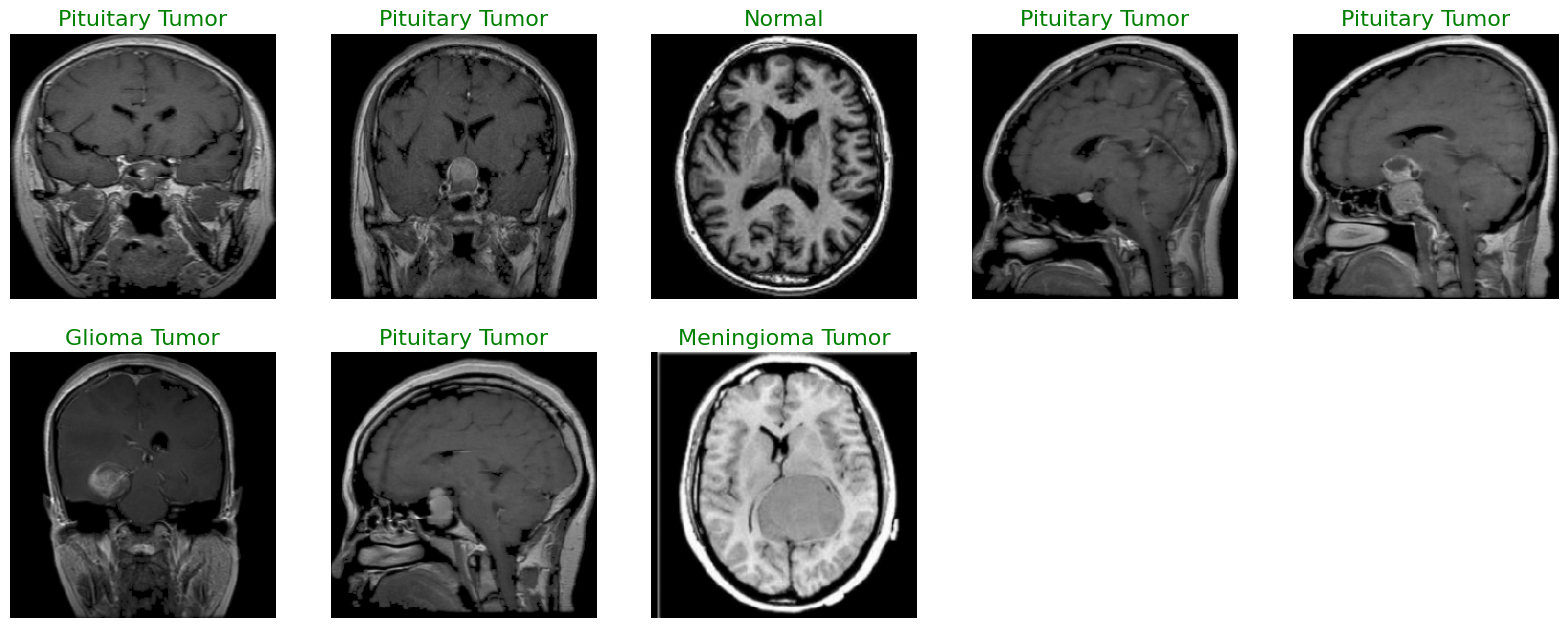

In [9]:
def show_Tumors_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_Tumors_images(train)

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

    
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

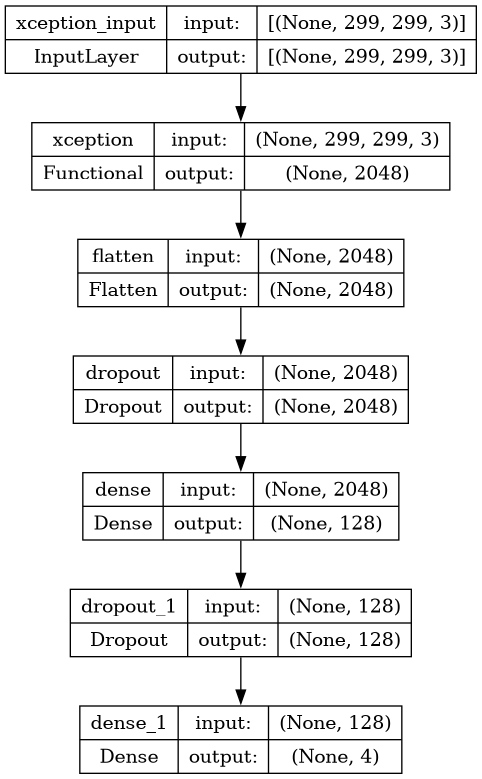

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10


I0000 00:00:1708280218.636855      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


310/310 [==============================] - 64s 123ms/step - loss: 0.7042 - accuracy: 0.7246 - precision: 0.8206 - recall: 0.6224 - val_loss: 0.2474 - val_accuracy: 0.9306 - val_precision: 0.9404 - val_recall: 0.9161
Epoch 2/10
310/310 [==============================] - 31s 101ms/step - loss: 0.2388 - accuracy: 0.9245 - precision: 0.9342 - recall: 0.9111 - val_loss: 0.2050 - val_accuracy: 0.9484 - val_precision: 0.9511 - val_recall: 0.9403
Epoch 3/10
310/310 [==============================] - 31s 101ms/step - loss: 0.1093 - accuracy: 0.9657 - precision: 0.9683 - recall: 0.9616 - val_loss: 0.1840 - val_accuracy: 0.9484 - val_precision: 0.9561 - val_recall: 0.9484
Epoch 4/10
310/310 [==============================] - 31s 101ms/step - loss: 0.0599 - accuracy: 0.9826 - precision: 0.9838 - recall: 0.9810 - val_loss: 0.1325 - val_accuracy: 0.9629 - val_precision: 0.9645 - val_recall: 0.9629
Epoch 5/10
310/310 [==============================] - 31s 101ms/step - loss: 0.0283 - accuracy: 0.9931 

In [13]:
history1 = model.fit(train, epochs=1, validation_data=val, verbose=1)

310/310 [==============================] - 31s 101ms/step - loss: 0.0230 - accuracy: 0.9939 - precision: 0.9943 - recall: 0.9939 - val_loss: 0.3879 - val_accuracy: 0.9371 - val_precision: 0.9371 - val_recall: 0.9371


In [14]:
model.evaluate(test, verbose=1)

117/117 [==============================] - 4s 32ms/step - loss: 0.2603 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580


[0.26030606031417847,
 0.9580193758010864,
 0.9580193758010864,
 0.9580193758010864]

In [15]:
model.save("Tumors.h5")

In [16]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

117/117 [==============================] - 4s 25ms/step


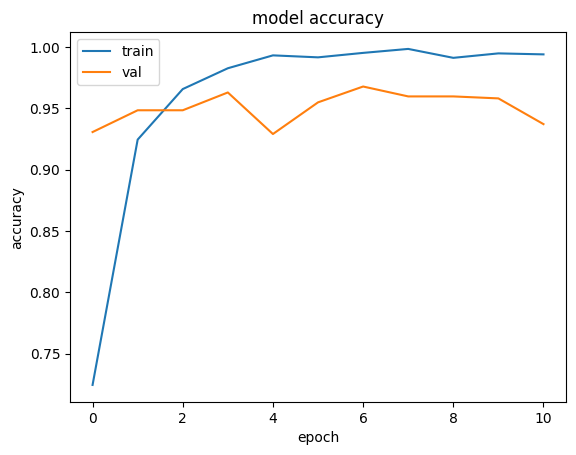

In [17]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

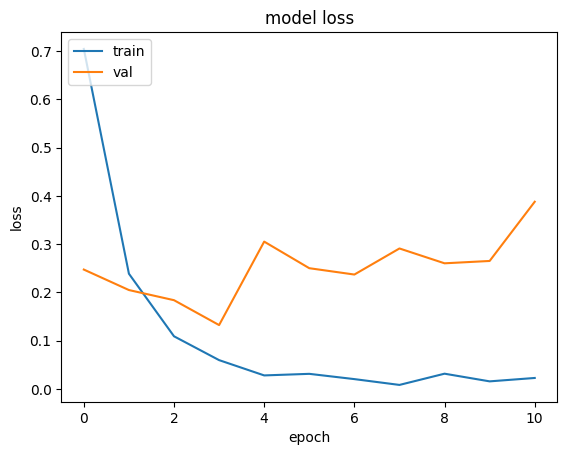

In [18]:
plt.plot(history.history['loss'] + history1.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels 
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

                  precision    recall  f1-score   support

    Glioma Tumor       0.97      0.93      0.95       288
Meningioma Tumor       0.92      0.95      0.94       268
          Normal       0.99      0.99      0.99       120
 Pituitary Tumor       0.97      0.98      0.97       253

        accuracy                           0.96       929
       macro avg       0.96      0.96      0.96       929
    weighted avg       0.96      0.96      0.96       929

Accuracy of the Model: 95.8%


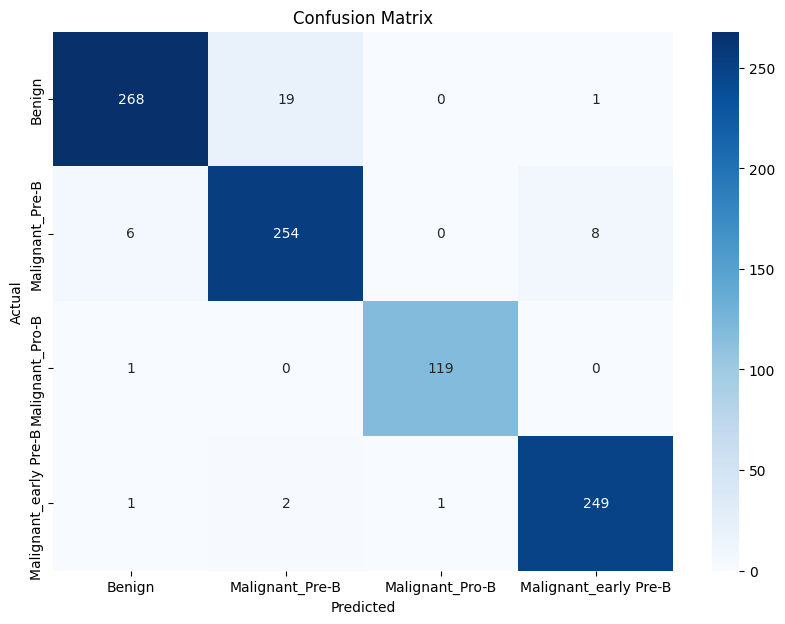

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()